In [1]:
# script to do gaussian least squares fitting of observed tau-mu* 
# author: sofia chelpon
# date created: 2-12-2020

In [6]:
import numpy as np 
import xarray as xr
import pandas as pd 
import datetime 
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import datetime as dt 

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [23]:
# ---------- read in data 
mypath2 = '/mnt/home/sofia/TTS/paper_2020/base_tts_code/test_tts_data.xlsx'
test_data = pd.read_excel(mypath2)
utbl = test_data.utbl.values
tau = test_data.tau.values

In [45]:
# ---------- prepare some inputs for the function 
# LT in seconds 
LT = tau*86400
# range of times that span all lifetimes, interval of 1/4 of a day 
time1 = LT[0]
time2 = LT[-1]+1
interval = 86400/4 
t = np.arange(time1, time2, interval)

# get exp decay matrix 
# used to get mu_star_integral
exp_decay_matrix = np.empty((len(LT), len(t)))
for ii, tt in enumerate(LT):
    exp_decay_matrix[ii] = np.exp(-t/tt)

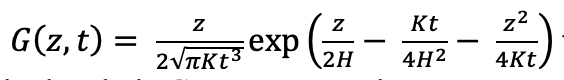

In [46]:
# ------------------------- greens function ----------------------------
# construct the analytical form of the greens function and use gauss newton least squares method
# follow schoeberl et al 2005 (see above MD cell)
def my_greens_func(k_coef, t):
    # z = mid level of sampling, 13 km, H is scale height of atmosphere 
    z = 1.3e4 
    H = 7.64e3 
    # use analytical form to solve for GF 
    a = z/(2*np.sqrt(np.pi*k_coef*(t**3)))
    b = (z/(2*H))-((k_coef*t)/(4*(H**2)))-((z**2)/(4*k_coef*t))
    my_gf = a*np.exp(b)
    # then get mu_star
    mu_star_matrix = np.empty((len(LT), len(t)))
    my_mu_star = np.empty((len(LT), 1))
    for ii, tt in enumerate(LT):
        mu_star_matrix[ii] = exp_decay_matrix[ii]*my_gf    
        my_mu_star[ii] = np.trapz(mu_star_matrix[ii], t)
    # return mu star and greens function 
    return [my_gf, my_mu_star]

In [40]:
##############################################################################################

In [41]:
# ------------------------- iteratively find best k value ----------------------------

0.007289433024321295 0.007287952900889257 135 0.9262784214943276


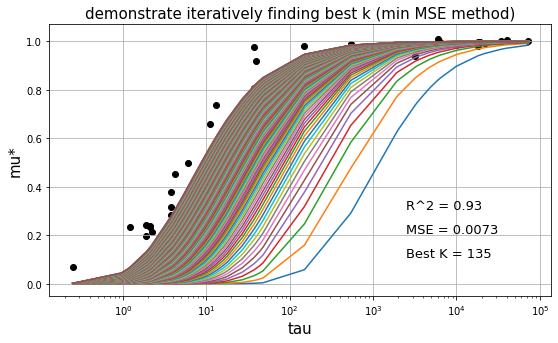

In [61]:
# start with a stupid low k value, define interval to incrase by 
k_coef = 1 
k_plus = 1
# huge MSE to start statement 
MSE_prev = 1000
MSE_now = 999

fig = plt.figure(figsize=(9, 5))
plt.scatter(LT/86400, utbl, color = 'k')
while (MSE_prev > MSE_now):
    # get greens function using k (first pass is dummy k, increases every iteration)
    out = my_greens_func(k_coef, t)
    my_gf = out[0]
    my_mu_star = out[1]
    # add mustar to plot 
    plt.semilogx(LT/86400, my_mu_star)
    # overwrite previous MSE from last lass, calculate new MSE
    MSE_prev = MSE_now
    MSE_now = mean_squared_error(utbl, my_mu_star)
    # increase k coefficient by 10 for next pass
    # will go as long as MSE is still improving
    k_coef = k_coef+k_plus
    r2 = r2_score(utbl, my_mu_star)
# rename output best k for use 
best_k = k_coef-(2*k_plus)
mse = MSE_prev
    
print(MSE_now, MSE_prev, best_k, r2)

plt.text(10**3.4, 0.31, 'R^2 = '+ str(round(r2, 2)), size=13)
plt.text(10**3.4, 0.21, 'MSE = '+ str(round(mse, 4)), size=13)
plt.text(10**3.4, 0.11, 'Best K = '+ str(round(best_k, 2)), size=13)

plt.grid(which = 'major')
plt.xlabel('tau', fontsize = 15)
plt.ylabel('mu*', fontsize = 15)
plt.title('demonstrate iteratively finding best k (min MSE method)', fontsize = 15)

# save 
fig.savefig('test_tts_compare.pdf')  

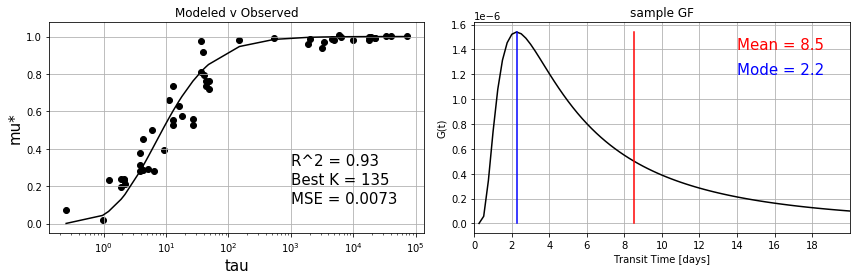

In [62]:
# https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
# use previous to now plot the best fit 
# use best_k to get 
out = my_greens_func(best_k, t)
my_gf = out[0]
my_mu_star = out[1]

# --------------- plot 
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
ax0, ax1 = axes

#### my mu star 
ax0.plot(LT/86400, my_mu_star, color = 'k')
ax0.scatter(LT/86400, utbl, color = 'k')
ax0.set_xscale('log')
ax0.grid(which = 'major')
ax0.set_title('Modeled v Observed')
ax0.set_xlabel('tau', fontsize = 15)
ax0.set_ylabel('mu*', fontsize = 15)

ax0.text(10**3, 0.11, 'MSE = '+ str(round(mse, 4)), size=15)
ax0.text(10**3, 0.31, 'R^2 = '+ str(round(r2, 2)), size=15)
ax0.text(10**3, 0.21, 'Best K = '+ str(round(best_k)), size=15)

#### my gf 
ax1.plot(t/86400, my_gf, color = 'k')

ax1.set_xlim([0, 20])
ax1.set_xticks(np.arange(0, 20, step=2))
ax1.grid(which = 'major')
ax1.set_title('sample GF')
ax1.set_ylabel('G(t)')
ax1.set_xlabel('Transit Time [days]')

# get mean, mode
peaks, _ = find_peaks(my_gf)
mode = t[peaks[0]]/86400
mean = np.trapz(my_gf*t, t)/86400

ax1.plot([mean, mean], [0, np.max(my_gf)], color = 'r')
ax1.plot([mode, mode], [0, np.max(my_gf)], color = 'b')

ax1.text(14, 1.4e-6, 'Mean = '+ str(round(mean, 1)), size=15, color = 'r')
ax1.text(14, 1.2e-6, 'Mode = '+ str(round(mode, 1)), size=15, color = 'b')

#ax1.annotate(('Mean = '+ str(round(mean, 1))), xy = (0.8, 0.95),
#            xytext=(0.8, 0.95), textcoords='axes fraction')

plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(-2,2))
plt.tight_layout()

fig.savefig('test_tts_compare_2.pdf')  